<a href="https://colab.research.google.com/github/Avani1994/Emjoi_Recognition/blob/main/GenerateTrainingData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install emojipy

     |████████████████████████████████| 71kB 2.1MB/s 
  Created wheel for emojipy: filename=emojipy-3.0.5-cp36-none-any.whl size=72322 sha256=0a40c405e5e49966c1b33a6490a7115c438813dd4cecac59900e8d694d9a02db
  Stored in directory: /root/.cache/pip/wheels/fe/9e/90/9e209df23796a4a996d5230ed77eb59fad2f6a0423e51ef4b1
Successfully built emojipy


In [ ]:
!pip3 install essential_generators

     |████████████████████████████████| 9.5MB 2.6MB/s 


In [ ]:
# %%cython
import os
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
import cv2
from google.colab.patches import cv2_imshow
import textwrap
from emojipy import Emoji
import re
import base64
from essential_generators import DocumentGenerator, MarkovTextGenerator, MarkovWordGenerator
import random
import csv
from numba import jit
random.seed(30)
#from reportlab.lib.styles import getSampleStyleSheet

In [ ]:
def rounded_rectangle(self: ImageDraw, xy, corner_radius, fill=None, outline=None):
    upper_left_point = xy[0]
    bottom_right_point = xy[1]
    self.rectangle(
        [
            (upper_left_point[0], upper_left_point[1] + corner_radius),
            (bottom_right_point[0], bottom_right_point[1] - corner_radius)
        ],
        fill=fill,
        outline=outline
    )
    self.rectangle(
        [
            (upper_left_point[0] + corner_radius, upper_left_point[1]),
            (bottom_right_point[0] - corner_radius, bottom_right_point[1])
        ],
        fill=fill,
        outline=outline
    )
    self.pieslice([upper_left_point, (upper_left_point[0] + corner_radius * 2, upper_left_point[1] + corner_radius * 2)],
        180,
        270,
        fill=fill,
        outline=outline
    )
    self.pieslice([(bottom_right_point[0] - corner_radius * 2, bottom_right_point[1] - corner_radius * 2), bottom_right_point],
        0,
        90,
        fill=fill,
        outline=outline
    )
    self.pieslice([(upper_left_point[0], bottom_right_point[1] - corner_radius * 2), (upper_left_point[0] + corner_radius * 2, bottom_right_point[1])],
        90,
        180,
        fill=fill,
        outline=outline
    )
    self.pieslice([(bottom_right_point[0] - corner_radius * 2, upper_left_point[1]), (bottom_right_point[0], upper_left_point[1] + corner_radius * 2)],
        270,
        360,
        fill=fill,
        outline=outline
    )


ImageDraw.rounded_rectangle = rounded_rectangle

In [ ]:
class EmojiConverter:
    def __init__(self):
        import requests
        import re
        self.data = requests.get('https://unicode.org/emoji/charts/full-emoji-list.html').text
    def to_base64_png(self, emoji, version=0):
        """For different versions, you can set version = 0 for , """
        html_search_string = r"<img alt='{}' class='imga' src='data:image/png;base64,([^']+)'>" #'
        print(emoji)
        if emoji == "☹":
          print('true')
          matchlist = ['iVBORw0KGgoAAAANSUhEUgAAAEgAAABICAMAAABiM0N1AAAABGdBTUEAALGPC/xhBQAAAAFzUkdCAK7OHOkAAADDUExURUdwTMZoB/OMA8aBKMpwE8ZvE8t7H/KiE8h9J7uGNs97HOaOItmCIfKKDsVpCu6RGdl3EP/aMf2uFvioFP/RL/+1Hv+6KP/4kP/OOP++Lv/2fu2bD//8uf/6pf/2a+WSDP/HOv/JLP7tQt+ICf/BOP/9zv/jM//HM9l+Bv7eRP/1WdV0Av/lWaRrD//ncf/+4/+oBf2XBJRbCoNJBcpqA//XUv+5Bv/JCeF6AlwkAHI7BLiKH+vUPN29NdCjJ//YDWcwAieNynsAAAARdFJOUwDv/hmmkE3+OApul4Hp0MnYbvsbCAAABklJREFUWMPV2ImSokgQBuD2QLzaHhQ5PAFtEQVWoL1AHd//qTYzqzhs7Wt3YiM2dTpGKD7/ShCFp6c/U42n/1c1KvVas92Cajdr9co/jN+oN1svYrff7+/hX78rvrTa9cqPmXr7Rezv9vv977T2+10fsPrPwrSeuztEFtZqMhkMBpOVtSCrK7Zq355ivSVukHF8dfT6F6/X0dh3JaA24jdTVdrPyEj+OENybOAg9dz+Rq/qL8Fut5cGI9ry1sGH6ux3u83Ll6FqEGf32x+9psWw17xGAxmk5+bnTrsM03LGMHz0Oips/copWjxyYXpB65OeN9oBOO54xOqWQiEt3/xcIscfjcbjcbYN0wrIGNeqn0rMGfMa5VhmjNKVY1VD6YM+l8lRVXWc10MFxowxU/lhx+vPm83OV1mNi1ix1DEfofrmZvP84ChovMDEtupgoOZ1y+WGqg5UX/X7m+Cl8rBBmu8PfPhkqUXtfcFaKBjobx+1qf4cbBTf5xKrO48ZqeP79ia4m1wLJ+ZTDSaDyaBQhe2pYDUb6G9hctXGfaCt67q+P/EnrN6D+JoVjPB919/6xiYo126garDpGlt364M1cSdf1AqHuTCcIt0H2sIqHLFyV6vVZPWRAutZwQbzd11ql4PNfIvlppJzPqGHIDx4nWghDnBptGF0g3Lr5hgKuoahbbcOlGvB4LMXx95pdVuXKI4SBxTHdZytg1I/CH5VbmdmGFsN1sIY17JO0TGOj6F161yv8fWaWJZj4RtuNc0w9E1wyNvdhJkpc0ODwhEwMLlGYRhdz1axQlwYRydiHAdGG3O9F5Tb2cyq5aCnzG2QHM2RUArj0PPCOCFgRU9IGYVeGMUXhCR8V8O2dWhSdihVfiGk2zaskySQFqcw8gCKvGKgMzioXywJCgOBowCUNam+JEi3TU3WcNBi4SHkRSzRgp6QiKDosoA302RZM21bQeiQHgC1Q3nY6yu6aZqyLKNkJSzR2VpAWfRcWKSH4WkBI2CgaZu6Al/l5azbTQalElA4N2h2Qk5aMDdcCIGQkWGwrij9HkDp+a2NUJdFyiR461sHJVhIHeKOqfT7vWH5IHBIOEwJyiRJlhbW6WQtpKIDy3BhlocCdXvD6aH6EDIJwo5L1Hj+kBZsN8A67pjmPTQbikWIU8TkEpWcQ7qiP4agSWxuZkG6L2RYIpqaOJxlUBsh6jYcSnkkOZ3aohCIFTE6BUIobXZzPWNN0pkkF2bH9zVvkcwkTARHNYOms3W6+2vrQw7ZQMmazLaW5PMlgX0eesnF5Iom2xoxOm/RbJ0ekPUSQGxuc5TgQ4fjNcm8eNH1yCoOE0WGTwY8NBozRwdaNF2u049IpXOYTRGiLqFjarjFxbsi4CVJEiIYJbqsZQw7irBF2Ye2UT1gk9jk5iySpulJfIy9y4l99E/nJDoeQ1HWbC2FIBDO7JB/IzXXSzY3kuDEBJLuwXZwYnMkmZ3wrBPI0QUSGfacHAoEM2vnp9rSMo0EbQKJnDihsyAVYo51Do/xBU9nACkUCPbZ8i0/1TY6PFIqGbZ3jM6OZmuFMgzHgcWiMWcOCzRbdgo/JIR1GolLl2sMjmEUHXwJkqcbqYMdWq6F4hdkCY9JikSSAud9x+BFhMH/gJRwhwVal26+s6sUKZO868XBGb4vWHSKYlHPneW6evsjooSSyKVh7GnkFKk59gYWnmOPOb0h7rK32x8RjTQSSV5o4GHANswerHTtEonk8EDvftqySEPK1E3O0IWMKhQezoqeTPuZU7r7FSm8FTNhp+4sYnBV7rwJ9xdFcCxxqUDhCQE+yToZjIHE0GdwEOo8uExik6PZ4fRyKyuuYBx0lst3uz77wY6TY31iFFmF6rI0vSzP2weXSAKXChRsmzHdbuoMuSN8cDHS4BIPxSm2eYpAGnRm6FQ/vDzKJaDI6nXZA//kzFcOl95RhSImdYTPL7abpTULhRRiYg89EZECsy41v7por3fSUEBRLpFAfAEKMhCnU/vG5bqAoRg1HZI2TBVgKI7wvVsb9WqJpSIrrRkpkKZU/fZtjUYNKbAQywperpGhWxrfv60hdNAijQr//1bqCLUf3/yp1JpVwLIqdart2k9v+zQKN6IEoVoVhH9xI+rP3o1r/GfvlNXf28CeWeGEtW4AAAAASUVORK5CYII=']
        if emoji == "✌️":
          matchlist = ['iVBORw0KGgoAAAANSUhEUgAAAEgAAABICAMAAABiM0N1AAAABGdBTUEAALGPC/xhBQAAAAFzUkdCAK7OHOkAAABaUExURUdwTNyWDuGbEbpzCNqWEaNdB8F5Csd3C5ZSBcB3CciCDNyaF710CcFwCsZ3CvK6Mf/WXv/VV//ST/7IOf/NQ/vCMPKxHfe7JuyoFeWfDd6TCdWFCbNiDIhCDRWNUoAAAAAQdFJOUwDX7Eu7I57+EjZlj3rXwuGdWlQzAAAEp0lEQVRYw6WX53ajMBCFQxXN2OoF8v6vuVNEcPaPrF3lnBybRB93rqbA11f1mqbqLfO6LsNf14a179e57s6rkS/17H6zn/L1ks+lBrQq2AOb3m8/9eqF61mhaXhKBL30+nZx8QzSFZI6zyD1fLOp1wSSZq0AOUUk6W+XpkYTXOoK0NwaBunt1zVS+Xat7FGj2W0z3ha5DPIVHk29JdDLND8ZuHnD7FCTSavj2NS9a8wg3QwVoC5ybHccU8Mile1rEnJoeZu0419XlB+rSqTn2CCQ6dZIFrmqEgGTODbTZpO2kC0KdVW7xBzJJaDn01e6Heq6SMuHpOyaM+v63ld2sN2xJ7onk7rstanzGkCjsyhBZpM2CJW93io75BY5FhPIpDFkUOgqQV1ytJXz5oq02mt0N5AkaTGThoZAUummuv3vkfdqDGZOnrqRsX0VaJq7YTwC2g32rphWBJLGrzU5tDbBtY2AzYpEoNcUp9I1BTI3zlqrfURJ7O/UkDr4/MmhzTD++mWCA/JaG619ggxAk2I3J84qZdtypS2t1bC734Sz2ihjbEwIgmTuIYvo9I0td7W5tQa2a3+eDjgKPoaDHFbWeUDzoZVPH/uGksrYdPIn8EM4rhKI1Cj69AEIqhtmGWRcPJ1hkAMQzQ1jLpAvphG1ZMgaZQiESONE4CENVBqYCiwsep0HEOTfGZAj4fbHBZI8LhFUDK3PA1l5Eej2YEhyDMoLzPJlj3qeo7BdRDIEbp+8fOfASfjy8a8anYH/dSJBXmvrXUgQmkSrFXsOF8sJOTrvoTKcCyK5EEKMCVaA7/gNZ4oCjo/FEhkj/j8A0ikCFAdoQmGYQQoRUDeo6ANQirTS8S2gXMH62x/JMUOC+1Cs/vE4EnHOUwgR9O/zQpiyILnc+3ckHIfAwM4zWao3TKCcjC/KrBCKja1HLbAO58P5DR3AejZJI/MKULtiRvZ4TBCd887F84zuXt7mHKO6KUkaA2+CFUISIgU8RUe/PTcRirPYIxmEHNgdkzhBXYAfWAE6HeQ6FSDke2Fmr4E5kHSYTcf5TccH64gYHJNAUanctsAcS5ICWP99LTAMg5MZVKiShUBYZJYk0SFmkggkCTjYAAqgLhLHUGky6RDiZFq8QNjUU1do/tTiqQNcKFyYoydMgQtkXUERPCZkEJEYRcWXDnG4+y8lEDzH4m25KgyJ4izChhJd1gqRhVJvG1lRjoBEcVYhj+6hSFDcy49o9kcSkrAh2Yyz1JdwjodUeojERzRuY1TxhNJM81i9htguHqXWhm7riySJBFuNvlsl6PEhPopzZA8kicy4RJkcYhYHnFR+PN4SS6KBzaJygFbzXAFOFOXnmqFFSbemHN9lOmZW/EQQ9v/gb5K6LefDI4745JVmbrFh3CR2iTjcpaD+PnuB2BKTtMkskwVxjwLO47PH9Wkn0oX6OTTqUFR0n74/zA/or79QF4eL9/MXGiZlFK83Ts0b1rAfjOKp9nPq2JfGqreHYRQJUNzBr5kCmFoOVu8DHgPwOeDqRtR0H8tX9ZqWHYbQkXKrJcw2fP3TGpZt3PcHrX3cuunrf9Y00Po/SNX6A09rokAGb+RUAAAAAElFTkSuQmCC']
        if emoji == "☺️":
          matchlist = ['iVBORw0KGgoAAAANSUhEUgAAAEgAAABICAMAAABiM0N1AAAABGdBTUEAALGPC/xhBQAAAAFzUkdCAK7OHOkAAADMUExURUdwTOaOIs58H8ZoB9N+H8pwE8ZvE/OhFch8JcaCKfSQEcdpCcVqCuuACuJ+EfKZHMVoC49MBf/JOf+ZEv/QNf/aM/+zH/6sE/6hEtd5BP/mNvmnFf+6KN+ICf+pHf/3juyaEP/6n/+PC//GKv/uR//7sP/8weWSDv/91PaaC//3Wv/4f//2bf/lQv+9MmEqAZBVB8trA+2NBv+6Cf/hYv/qeP/PCm42Ap1kEP/+5+F7Af/WTnpCBIVMB+XUTK16HMWRJNmrJ+y6McuyRfRRkFMAAAASdFJOUwCVVvN6pY/+OhPl5tTwzsrK6ZPFX64AAAY/SURBVFjD1Zh7d6I8EIdXRcXWbntAAQXv9YIi4G1liwji9/9O78wkIKh12z37z/uLVk8yPp2ZJEPgx49/o9qP/5lqYlEQCiBBKIq1v4YIhdeqqigbA5qiVl8Lwl/ARIAom185bRSAid/EPKlEaS/nlrVYWNZ82SaWWv0GSixUCbO0epPZb67ZZLBbNr+DqgngzeZXczdOIRfYYvlrs1GfCl/IlfiqEWYyQ/3GhojfM6ZJD1Ha6x+dKpI72/HsU012DXSq+JgjmJCd5mDCNJvkCDPePd5CpszCI04FOdvxBFsedaGMYXA32qjyg0QJQ+DsxokmN0qHekAaFh5xRrvxAHQLGyeUARqMe43PScW1BpxBb5BofC1ikHoDSLk2vJtx8UlTN9seanBhDW4Ygx6z2Y1U7enOKqj9lNWN3+vtelwZ1wZXENBu19tCwn/W7iRI20g7UG+xWPQW6S8QSC3RAg12QNr5EFzhNjBZNbY70oIri7swSMwQgnu5Dq4ADvlbJFmw10mLO+IjFthtQYo2LF859IIOkazt8RyGnheet1csa3uOQi8Mo+PWsshWUuV1fubKQ02VGOjkHfYOau+erZyOIR84eJGPpr5/7ZL4MtQM3/e3fuyR5SEIABfMc6DQcbCf/o97AmPft1U5lyVhLasS9PvR3tkHYXQ+gs7nszXPCnpYf+iCWYT2EFt24mo/MTIgxXvHOx/n8HsLnZlfyWIDcwuyuHdOwJEgtsxaosgkIB2j43z+/r58Z5pjwxf74L1LGAb3ohg4kq0NM7EJa5NADR+smN4/Ex/34VsDQao5FDJzBiAbQKBm8xGKj4FVAzGSbXfNYbmWpmht6oY9GjEUWDXby2V72X7HxoVfsRPeTcQ0JCCNbKNrrtMkiS8IQhJI4iTQEt7vbS72JaE0yNa2DQR9JEkqfgBIMUgjAwwQ1b4VsYCDDDBkUgGULG6BQIpiKPjHMOi/xSdQI8sZYU9Mg4ZB5vhXB5CQBakKqUsW09A97EFBlHrWjALoOBzccEqALpkqKoIqybWDQN1Eat+DhQu/OeD6bTdZC2nnAN7Ze9WLsY6gcgZEJI20DmBLuaTACdtIgZfrJH17xzWZJYK0PKhv6jqMyCBtxTie57mBe8JpQpdO1OMh6eC00BJJmm7mQbC0oRc5Q3nqBl50io/HJbzahKGVdTw2j8f4FHkHdwpmDKWZ/QtI+OggiDAguUpzw5ZAM1U69fGpyuyIhKAk2UILQKbGOWABsSsGohrNnABjKDCY2CHJXHdayfQXW5ht+QKSNQbKcQDLQJqcAZkIShakWMJs3wOhT40EgyDjCiRjZKtki9TqmCTzAtK6CYj9nmhsh2FomnzhmOv1x3Na2coJiGYNHeriHm4wMRZJApe6yexyUOcjLSOQbYyNk2SWa2MkNW5Eu4yTGCeba0pSMm+AYSA7qU4ZUQHCaeuSpQagfueSIkjSGyyAPq57hsHAbCyAjUujgoglkZG6tIbM/rTTqmcOEpVVqwOx8f2DgTFQhiVJvLYamKYubUx0qNWqZC+QpVZnCi5VidMFTArKCwdshXF0s4oOlXLHiHILSVVd11OHblk26zVsqEaqquvEaeVPEehSp48kVVUIZEuRG+VQcejF5BKWNVXXqn0Era6Of9wlJCmMJJ0cx4tizrL7YeB45JBBhVGvcoeuzmzic0JSGQmuc1QUvTDqRBFc7eFMAQ4ZjJMGVro5RcLE8TSpHAWkPVXuPdZXKLMniWGQQ/5AYJXbw+gbLAGecFWhS4EdQw1z8SATBPARSSmG/MEE1e+c/llwPE/klDKKw8D1qMQG3kkiCguLcVrPd2+SihgczziicPqkyGMlP4xH5Axzh3NWwie3NJzEUF1iQWGN4NR4gvqhcoyO806c8mf3jnkSXKAQhVdeRunqOnOH8gycT2+PEhKhGItizFKYO485SCohCZ1CFLEyIkzCqTy+ry0+p04xFtCokS6YZ+GPN8dvK+ZUloUMRgEMcupfuGOvVZ5TFLESTVNMqfK1RxtiuQQoxiIcqcMogCl//VlEkaEIdlGLYYrfetIiVt5KKwZrddjHCij1ivjt5zU1USjXAZaoVC8Lf/sMqYYPoiqVcrlSwQdR/7fnaP/K3/8A3VK6uAGLBf0AAAAASUVORK5CYII=']
        if emoji != "☹" and emoji != "✌️" and emoji != "☺️":
          matchlist = re.findall(html_search_string.format(emoji), self.data)
        #<img alt="☹" class="imga" src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEgAAABICAMAAABiM0N1AAAABGdBTUEAALGPC/xhBQAAAAFzUkdCAK7OHOkAAADDUExURUdwTMZoB/OMA8aBKMpwE8ZvE8t7H/KiE8h9J7uGNs97HOaOItmCIfKKDsVpCu6RGdl3EP/aMf2uFvioFP/RL/+1Hv+6KP/4kP/OOP++Lv/2fu2bD//8uf/6pf/2a+WSDP/HOv/JLP7tQt+ICf/BOP/9zv/jM//HM9l+Bv7eRP/1WdV0Av/lWaRrD//ncf/+4/+oBf2XBJRbCoNJBcpqA//XUv+5Bv/JCeF6AlwkAHI7BLiKH+vUPN29NdCjJ//YDWcwAieNynsAAAARdFJOUwDv/hmmkE3+OApul4Hp0MnYbvsbCAAABklJREFUWMPV2ImSokgQBuD2QLzaHhQ5PAFtEQVWoL1AHd//qTYzqzhs7Wt3YiM2dTpGKD7/ShCFp6c/U42n/1c1KvVas92Cajdr9co/jN+oN1svYrff7+/hX78rvrTa9cqPmXr7Rezv9vv977T2+10fsPrPwrSeuztEFtZqMhkMBpOVtSCrK7Zq355ivSVukHF8dfT6F6/X0dh3JaA24jdTVdrPyEj+OENybOAg9dz+Rq/qL8Fut5cGI9ry1sGH6ux3u83Ll6FqEGf32x+9psWw17xGAxmk5+bnTrsM03LGMHz0Oips/copWjxyYXpB65OeN9oBOO54xOqWQiEt3/xcIscfjcbjcbYN0wrIGNeqn0rMGfMa5VhmjNKVY1VD6YM+l8lRVXWc10MFxowxU/lhx+vPm83OV1mNi1ix1DEfofrmZvP84ChovMDEtupgoOZ1y+WGqg5UX/X7m+Cl8rBBmu8PfPhkqUXtfcFaKBjobx+1qf4cbBTf5xKrO48ZqeP79ia4m1wLJ+ZTDSaDyaBQhe2pYDUb6G9hctXGfaCt67q+P/EnrN6D+JoVjPB919/6xiYo126garDpGlt364M1cSdf1AqHuTCcIt0H2sIqHLFyV6vVZPWRAutZwQbzd11ql4PNfIvlppJzPqGHIDx4nWghDnBptGF0g3Lr5hgKuoahbbcOlGvB4LMXx95pdVuXKI4SBxTHdZytg1I/CH5VbmdmGFsN1sIY17JO0TGOj6F161yv8fWaWJZj4RtuNc0w9E1wyNvdhJkpc0ODwhEwMLlGYRhdz1axQlwYRydiHAdGG3O9F5Tb2cyq5aCnzG2QHM2RUArj0PPCOCFgRU9IGYVeGMUXhCR8V8O2dWhSdihVfiGk2zaskySQFqcw8gCKvGKgMzioXywJCgOBowCUNam+JEi3TU3WcNBi4SHkRSzRgp6QiKDosoA302RZM21bQeiQHgC1Q3nY6yu6aZqyLKNkJSzR2VpAWfRcWKSH4WkBI2CgaZu6Al/l5azbTQalElA4N2h2Qk5aMDdcCIGQkWGwrij9HkDp+a2NUJdFyiR461sHJVhIHeKOqfT7vWH5IHBIOEwJyiRJlhbW6WQtpKIDy3BhlocCdXvD6aH6EDIJwo5L1Hj+kBZsN8A67pjmPTQbikWIU8TkEpWcQ7qiP4agSWxuZkG6L2RYIpqaOJxlUBsh6jYcSnkkOZ3aohCIFTE6BUIobXZzPWNN0pkkF2bH9zVvkcwkTARHNYOms3W6+2vrQw7ZQMmazLaW5PMlgX0eesnF5Iom2xoxOm/RbJ0ekPUSQGxuc5TgQ4fjNcm8eNH1yCoOE0WGTwY8NBozRwdaNF2u049IpXOYTRGiLqFjarjFxbsi4CVJEiIYJbqsZQw7irBF2Ye2UT1gk9jk5iySpulJfIy9y4l99E/nJDoeQ1HWbC2FIBDO7JB/IzXXSzY3kuDEBJLuwXZwYnMkmZ3wrBPI0QUSGfacHAoEM2vnp9rSMo0EbQKJnDihsyAVYo51Do/xBU9nACkUCPbZ8i0/1TY6PFIqGbZ3jM6OZmuFMgzHgcWiMWcOCzRbdgo/JIR1GolLl2sMjmEUHXwJkqcbqYMdWq6F4hdkCY9JikSSAud9x+BFhMH/gJRwhwVal26+s6sUKZO868XBGb4vWHSKYlHPneW6evsjooSSyKVh7GnkFKk59gYWnmOPOb0h7rK32x8RjTQSSV5o4GHANswerHTtEonk8EDvftqySEPK1E3O0IWMKhQezoqeTPuZU7r7FSm8FTNhp+4sYnBV7rwJ9xdFcCxxqUDhCQE+yToZjIHE0GdwEOo8uExik6PZ4fRyKyuuYBx0lst3uz77wY6TY31iFFmF6rI0vSzP2weXSAKXChRsmzHdbuoMuSN8cDHS4BIPxSm2eYpAGnRm6FQ/vDzKJaDI6nXZA//kzFcOl95RhSImdYTPL7abpTULhRRiYg89EZECsy41v7por3fSUEBRLpFAfAEKMhCnU/vG5bqAoRg1HZI2TBVgKI7wvVsb9WqJpSIrrRkpkKZU/fZtjUYNKbAQywperpGhWxrfv60hdNAijQr//1bqCLUf3/yp1JpVwLIqdart2k9v+zQKN6IEoVoVhH9xI+rP3o1r/GfvlNXf28CeWeGEtW4AAAAASUVORK5CYII=">
        #print(matchlist)
        #print(version)
        return matchlist[version]

def getEmojiImage(emoji, version=0):
  e = EmojiConverter()
  b64 = e.to_base64_png(emoji, version)
  #print(type(b64))
  x = base64.b64decode(b64)
  #print(type(x))
  with open("imageToSave.png", "wb") as fh:
      fh.write(x)
getEmojiImage(u"\u2639")

☹
true


In [ ]:
#pdf_content = "It's emoji time \u263A \U0001F61C. Let's add some cool emotions \U0001F48F \u270C. And some more \u2764 \U0001F436"
pdf_content = "🤰 xyz"
x = Emoji.to_image(pdf_content)
text = x.replace('class="emojione"', 'height=%s width=%s' %
                        (300, 300))
y = re.sub('alt="'+Emoji.shortcode_regexp+'"', '', text)
print(y)


<img class="emojione " style="" alt="🤰" src="https://cdn.jsdelivr.net/emojione/assets/3.0/png/64/1f930.png"/> xyz


In [ ]:
def generateRandomSentence():
  gen = DocumentGenerator(text_generator=MarkovTextGenerator(), word_generator=MarkovWordGenerator())
  return gen.sentence()

In [ ]:
import base64
import io
from PIL import Image

def img_to_bytes(filename):
    msg = b"<plain_txt_msg:img>"
    with open(filename, "rb") as imageFile:
        msg = msg + base64.b64encode(imageFile.read())
    msg = msg + b"<!plain_txt_msg>"
    return msg

def decode_img(msg):
    msg = msg[msg.find(b"<plain_txt_msg:img>")+len(b"<plain_txt_msg:img>"):
              msg.find(b"<!plain_txt_msg>")]
    msg = base64.b64decode(msg)
    buf = io.BytesIO(msg)
    img = Image.open(buf).convert("RGBA")
    return img

# filename = 'test.png'
# msg = img_to_bytes(filename)
# img = decode_img(msg)
# img.show()

In [ ]:
my_sequence = ["😍","😇","😃","😚","🤔","😴","😠","🤨","😭","😋","😁","😄","😃","😀","😆","😅","😂","🤣","☺️","😊","😇","🙂",
              "🙃","😉","😌","🥰","😘","😗","😙","😚","😋","😛","😝","😜","🤪","🤓",
              "😎","🤩","🥳","😟","😔","😞","😒","😏","😕","🙁","😣","😖","😫","😩","🥺","😢","😭","😠","😡","🥵","😱",
              "😨","😰","😥","😓","🤗","🤔","🤭","🤫","🤥","😶","😐","😑","😬","🙄",
              "😯","😦","😧","😮","😲","🤤","😪","🤢","🤮","🤧","😷","🤒","🤕","🤑","👍","👎","👊","🤞","✌️","🤟","🤜","👌", u"\u2639"]
def generateRandomEmoji():
  my_choice = random.choice(my_sequence)
  return my_choice
print(generateRandomEmoji())

😬


In [ ]:
emojiToSmallPILImage = {}
emojiToLargePILImage = {}
def generateEmojiImageHashmap(seq):
  for emoji in seq:
      getEmojiImage(emoji)
      largebyte = img_to_bytes('imageToSave.png')
      imLarge = Image.open('imageToSave.png')
      emojiToLargePILImage[emoji] = largebyte
      # x,y = im.size
      imSmall = imLarge.resize((24, 24), resample = Image.LANCZOS)
      imSmall.save('small.png', quality=95)
      smallbyte = img_to_bytes('small.png')
      imSmall = Image.open('small.png').convert("RGBA")
      emojiToSmallPILImage[emoji] = smallbyte
  print(emojiToSmallPILImage)
  print(emojiToLargePILImage)

generateEmojiImageHashmap(my_sequence)





😍
😇
😃
😚
🤔
😴
😠
🤨
😭
😋
😁
😄
😃
😀
😆
😅
😂
🤣
☺️
😊
😇
🙂
🙃
😉
😌
🥰
😘
😗
😙
😚
😋
😛
😝
😜
🤪
🤓
😎
🤩
🥳
😟
😔
😞
😒
😏
😕
🙁
😣
😖
😫
😩
🥺
😢
😭
😠
😡
🥵
😱
😨
😰
😥
😓
🤗
🤔
🤭
🤫
🤥
😶
😐
😑
😬
🙄
😯
😦
😧
😮
😲
🤤
😪
🤢
🤮
🤧
😷
🤒
🤕
🤑
👍
👎
👊
🤞
✌️
🤟
🤜
👌
☹
true
{'😍': b'<plain_txt_msg:img>iVBORw0KGgoAAAANSUhEUgAAABgAAAAYCAMAAADXqc3KAAADAFBMVEVHcEzdfRnjgRXIawvJagTbfBTMbg7gfRrbexbefBbKawfKawrlfgbuihTTcg3zig3kfAz5nxfziAv1lxnshA6xYAqvYAj/PjClZwf/yjr6qxb9sRr/0DX2pRL/+ov+tyHYeQbxnxL/NSf+2TLmkw3rmQ7ScgL/xDb/+Zj//dLbgAf//MT//eL//Lj/+qP+vjL9uSz0synehwn/+Xr+RDfijQv/+638Kh3+4jT9TkGVWAXqlRz+mwX/uwf/qgbsoST/6G7/8Vr7XFF3PwPyqiX/9WieYAfvIBbNDgr/zgr3xCn7bWT9gnuLTwX+32HfFQ7jiBf+1E7/7X33jgT+7EZoMQLlPDG8LAjPTQ3rjQX+lpD/8IvRMQ3SkR/UZBHrTUf/rqi9CQXbLx7wuU7hnSCzCATjbyX/29fqijD/xsHBgxqsbRK4fBf/3Rf/yJxvb29wcHBxcXFycnJzc3N0dHR1dXV2dnZ3d3d4eHh5eXl6enp7e3t8fHx9fX1+fn5/f3+AgICBgYGCgoKDg4OEhISFhYWGhoaHh4eIiIiJiYmKioqLi4uMjIyNjY2Ojo6Pj4+QkJCRkZGSkpKTk5OUlJSVlZWWlpaXl5eYmJiZmZmampqbm5ucnJydnZ2enp6fn5+goKChoaGioqKjo6OkpKSlpaWmpqanp6eoqKipqamqqqqrq6usrKytra2urq6vr6+wsLCxsbGysrKzs7O0tL

In [ ]:
def getSentenceDim(sentence, font):
    fontwidth, fontheight = font.getsize(sentence)
    s_height = fontheight
    # print(s_width, "swidth")
    s_width = int(7.5 *len(sentence))

    #if sentence consists of different lines
    textwidth = 0
    #print(s_width, "sentence width")
    textheight = 0
    if(fontwidth > 40):
      lines = textwrap.wrap(sentence, width=40)
      lines[-1] = lines[-1][:30] if len(lines[-1]) > 30 else lines[-1]
      for line in lines:
        line_width, line_height = font.getsize(line)
        textwidth = max(textwidth, int(7.5 * len(line)))
        textheight += line_height
      s_height = textheight
      #print(textwidth, "linewidth")
      s_width = textwidth
    return (s_width, s_height)

def drawChatBubble(x1, y1, x2, y2, draw, color):
    #print(str(x1), str(y1),"1st", str(x2), str(y2), "2nd", "chat bubble coordinates")
    draw.rectangle([(x1, y1), (x2, y2)] ,fill=color, outline=color)
    return draw

def drawTextAndReturnEmojiCoordinates(x, y, sentence, font, draw, image, text_color):
    sentwidth, sentheight = getSentenceDim(sentence, font)
    # print(sentence, "full sentence")
    textwidth = sentwidth - 0 * len(sentence)
    fontw, fonth = font.getsize(sentence)

    #if sentence consists of different lines
    nextYfortext = y
    textheight = 0
    if(fontw > 40):
      lines = textwrap.wrap(sentence, width=40)
      lines[-1] = lines[-1][:30] if len(lines[-1]) > 30 else lines[-1]
      # print(lines[-1], "endline")
      fullwidth, lastlineheight = getSentenceDim(lines[-1], font)
      textwidth = fullwidth -  0 * len(lines[-1])
      for line in lines:
        textheight = nextYfortext
        line_width, line_height = font.getsize(line)
        draw.text((x, nextYfortext), line, font=font, fill=text_color)
        nextYfortext += line_height
    else:
        draw.text((x,nextYfortext), sentence, font=font, fill=text_color)
    #print(x, max(textheight,y), x+textwidth, max(textheight,y)+ lastlineheight, "text coordinates******")
    #draw.rectangle([(x,max(textheight,y)), (x+textwidth,max(textheight,y)+ lastlineheight)], outline="#FF0000")
    return draw, x + textwidth + 10, max(textheight,y)

def generateChatBubble(image, draw, font, sent, text_color, chatBubbleX, chatBubbleY, chatBubbleW, chatBubbleH, numEmoji, color, blueTick, id):
    #print(chatBubbleW+26, "chat bubble x2 coordinate")
    boundingboxesandchar = []
    draw = drawChatBubble(chatBubbleX, chatBubbleY-5, chatBubbleX+chatBubbleW+28, chatBubbleY+chatBubbleH+10, draw, color)
    draw, emojix, emojiy = drawTextAndReturnEmojiCoordinates(chatBubbleX+6, chatBubbleY, sent, font, draw, image, text_color)
    #print(emojix, emojiy)
    #print(draw)
    for i in range(numEmoji):
      singleout = {'id': 'image'+ str(id), 'boxes' : []}
      emoji = generateRandomEmoji()
      singleout['char'] = emoji
      #print(emoji)
      emojiByte = emojiToSmallPILImage[emoji]
      im = decode_img(emojiByte)

      #getEmojiImage(emoji)
      #im = Image.open('imageToSave.png')
      # x,y = im.size
      #im3 = im.resize((24, 24), resample = Image.LANCZOS)
      #im3.save('small.png', quality=95)
      #im = Image.open('small.png').convert("RGBA")
      #print(x,y)
      image.paste(im, (emojix, emojiy, emojix+24,emojiy+24), mask=im)
      draw.rectangle([(emojix, emojiy), (emojix+24,emojiy+24)], outline="#0000FF")
      singleout['boxes'].extend([emojix, emojiy, emojix+24,emojiy+24])
      boundingboxesandchar.append(singleout)
      emojix = emojix + 24 + 1

    if(blueTick):
      blueTick = Image.open('bluetickbold24x15.png').convert("RGBA")
      image.paste(blueTick, (chatBubbleX+chatBubbleW+28-24, chatBubbleY+chatBubbleH+10-15, chatBubbleX+chatBubbleW+28, chatBubbleY+chatBubbleH+10), mask=blueTick)
      draw.rectangle([(chatBubbleX+chatBubbleW+28-24,chatBubbleY+chatBubbleH+10-15), (chatBubbleX+chatBubbleW+28-24+24,chatBubbleY+chatBubbleH+10-15+15)], outline="#008000")
      singleout = {'id': 'image' + str(id), 'boxes' : []}
      singleout['char'] = ''
      singleout['boxes'].extend([chatBubbleX+chatBubbleW+28-24,chatBubbleY+chatBubbleH+10-15,chatBubbleX+chatBubbleW+28-24+24,chatBubbleY+chatBubbleH+10-15+15])
      boundingboxesandchar.append(singleout)
    return draw, image, boundingboxesandchar



In [ ]:
def generateChatImage(imagewidth, imageheight, color, id):
  image = Image.new('RGB', (imagewidth, imageheight), color = color)
  fontsize = 15
  font = ImageFont.truetype('/usr/share/fonts/truetype/OpenSansEmoji.ttf', fontsize)
  text_color = (0, 0, 0)
  bg_color = (236, 229, 221)
  start_y = 146
  y = start_y
  draw = ImageDraw.Draw(image)
  text_color = (0, 0, 0)
  header = Image.open('header.jpeg').convert("RGBA")
  footer = Image.open('footer.jpeg').convert("RGBA")
  # x,y = footer.size
  # print(x,y)
  # print(imagewidth, imageheight)
  image.paste(header, (0, 0, 600, 141), mask=header)
  image.paste(footer, (0, imageheight-125), mask=footer)
  #height-125
  boxes = []
  while(y < imageheight-125):
    #print(y, imageheight)
    sent = generateRandomSentence()
    sentWidth, sentHeight = getSentenceDim(sent, font)
    #case when start y satisfies while condition but ending doesn't
    if(y + sentHeight + 10 + 20 > imageheight-125):
      break
    numEmoji = random.randint(0,5)
    emojiWidth = numEmoji * 24 + 1 * (numEmoji - 1) + 10 #padding for emoji
    # print(emojiWidth, sentWidth, "emoji and sent width")
    emojiSentWidth = emojiWidth + sentWidth
    # print(emojiSentWidth, "boxwidth")
    direction = random.randint(1,1000)
    if(direction % 2 == 0):
      draw, image, out = generateChatBubble(image, draw, font, sent, text_color, 10, y, emojiSentWidth, sentHeight, numEmoji,"#FFFFFF", False, id)
    else:
      # l = imagewidth-w-10
      # m = l+emojiSentWidth
      # print(str(l), "right text x1 coordinate")
      # print(str(m), "right text x2 coordinate")
      draw, image, out = generateChatBubble(image, draw, font, sent, text_color, imagewidth-emojiSentWidth-10-26, y, emojiSentWidth, sentHeight, numEmoji, "#DCF8C6", True, id)
    boxes.extend(out)
    y = y + sentHeight + 10 + 20

  print("saving image" + str(id))
  image.save('ChatImageDataSample/image'+str(id)+'.png')
  keys = boxes[0].keys()
  with open('outputsample.csv', 'a+') as output_file:
    dicWriter = csv.DictWriter(output_file,keys)
    dicWriter.writerows(boxes)
    #dic.writeheader()

  print("wrote output coordinates for", str(id))
  #return image, boxes






In [ ]:
def generateChatData(i):
  # print("hello")
  generateChatImage(600,1000,(236, 229, 221), i)


In [ ]:
#result = []
#import multiprocessing
#multiprocessing.cpu_count()
# pool = multiprocessing.Pool(4)
# pool.map(generateChatData, range(12))
dic = {'id':'', 'boxes':'', 'char':''}
keys = dic.keys()
with open('outputsample.csv', 'w') as output_file:
    dic = csv.DictWriter(output_file, keys)
    dic.writeheader()
for i in range(1):
    generateChatData(i)
    # result.extend(boxes)
    # image.save('ChatImageData/image'+str(i)+'.png')
    # img = cv2.imread('pil_text.png', cv2.IMREAD_UNCHANGED)
    # cv2_imshow(img)
# print(result)

# keys = result[0].keys()
# with open('output.csv', 'w') as output_file:
#     dict_writer = csv.DictWriter(output_file, keys)
#     dict_writer.writeheader()
#     dict_writer.writerows(result)


saving image0
wrote output coordinates for 0


In [ ]:

{'image0': [
            {'boxes': [251, 165, 275, 189], 'char': '😩'},
            {'boxes': [276, 165, 300, 189], 'char': '😖'},
            {'boxes': [343, 177, 367, 192], 'char': ' '},
            {'boxes': [471, 250, 495, 274], 'char': '😋'},
            {'boxes': [568, 264, 592, 279], 'char': ' '},
            {'boxes': [446, 299, 470, 323], 'char': '😐'},
            {'boxes': [471, 299, 495, 323], 'char': '😭'},
            {'boxes': [496, 299, 520, 323], 'char': '\U0001f97a'},
            {'boxes': [521, 299, 545, 323], 'char': '😚'},
            {'boxes': [546, 299, 570, 323], 'char': '😛'},
            {'boxes': [568, 312, 592, 327], 'char': ' '},
            {'boxes': [251, 366, 275, 390], 'char': '🤧'},
            {'boxes': [276, 366, 300, 390], 'char': '🙄'},
            {'boxes': [301, 366, 325, 390], 'char': '😆'},
            {'boxes': [326, 366, 350, 390], 'char': '😪'},
            {'boxes': [351, 366, 375, 390], 'char': '🤔'},
            {'boxes': [448, 380, 472, 395], 'char': ' '},
            {'boxes': [285, 448, 309, 463], 'char': ' '},
            {'boxes': [243, 483, 267, 507], 'char': '\U0001f973'},
            {'boxes': [268, 483, 292, 507], 'char': '🙃'},
            {'boxes': [293, 483, 317, 507], 'char': '😶'},
            {'boxes': [318, 483, 342, 507], 'char': '😷'},
            {'boxes': [343, 483, 367, 507], 'char': '😉'},
            {'boxes': [373, 497, 397, 512], 'char': ' '},
            {'boxes': [446, 551, 470, 575], 'char': '😏'},
            {'boxes': [471, 551, 495, 575], 'char': '😭'},
            {'boxes': [568, 565, 592, 580], 'char': ' '},
            {'boxes': [198, 600, 222, 624], 'char': '😧'},
            {'boxes': [223, 600, 247, 624], 'char': '😝'},
            {'boxes': [248, 600, 272, 624], 'char': '👊'},
            {'boxes': [270, 614, 294, 629], 'char': ' '},
            {'boxes': [48, 687, 72, 711], 'char': '😙'},
            {'boxes': [73, 687, 97, 711], 'char': '😗'},
            {'boxes': [98, 687, 122, 711], 'char': '😓'},
            {'boxes': [398, 697, 422, 712], 'char': ' '},
            {'boxes': [123, 751, 147, 775], 'char': '😖'},
            {'boxes': [148, 751, 172, 775], 'char': '\U0001f973'},
            {'boxes': [173, 751, 197, 775], 'char': '😷'},
            {'boxes': [198, 751, 222, 775], 'char': '👊'},
            {'boxes': [223, 751, 247, 775], 'char': '😥'},
            {'boxes': [448, 761, 472, 776], 'char': ' '},
            {'boxes': [41, 815, 65, 839], 'char': '😞'},
            {'boxes': [66, 815, 90, 839], 'char': '😃'},
            {'boxes': [373, 825, 397, 840], 'char': ' '}]}


{'image0': [
            {'boxes': [416, 165, 440, 189], 'char': '\U0001f975'},
            {'boxes': [441, 165, 465, 189], 'char': '🤥'},
            {'boxes': [568, 179, 592, 194], 'char': ' '},
            {'boxes': [513, 214, 537, 238], 'char': '😚'},
            {'boxes': [538, 214, 562, 238], 'char': '😌'},
            {'boxes': [568, 228, 592, 243], 'char': ' '},
            {'boxes': [308, 296, 332, 311], 'char': ' '},
            {'boxes': [521, 331, 545, 355], 'char': '😍'},
            {'boxes': [546, 331, 570, 355], 'char': '😓'},
            {'boxes': [568, 344, 592, 359], 'char': ' '},
            {'boxes': [138, 417, 162, 441], 'char': '👌'},
            {'boxes': [163, 417, 187, 441], 'char': '🙃'},
            {'boxes': [188, 417, 212, 441], 'char': '😅'},
            {'boxes': [398, 427, 422, 442], 'char': ' '},
            {'boxes': [496, 462, 520, 486], 'char': '😃'},
            {'boxes': [521, 462, 545, 486], 'char': '😀'},
            {'boxes': [546, 462, 570, 486], 'char': '😩'},
            {'boxes': [568, 476, 592, 491], 'char': ' '},
            {'boxes': [446, 511, 470, 535], 'char': '😯'},
            {'boxes': [471, 511, 495, 535], 'char': '🙂'},
            {'boxes': [496, 511, 520, 535], 'char': '🤜'},
            {'boxes': [521, 511, 545, 535], 'char': '😣'},
            {'boxes': [546, 511, 570, 535], 'char': '🤥'},
            {'boxes': [568, 525, 592, 540], 'char': ' '},
            {'boxes': [251, 579, 275, 603], 'char': '🤞'},
            {'boxes': [318, 593, 342, 608], 'char': ' '},
            {'boxes': [41, 666, 65, 690], 'char': '🤒'},
            {'boxes': [340, 676, 364, 691], 'char': ' '},
            {'boxes': [236, 726, 260, 750], 'char': '🤜'},
            {'boxes': [261, 726, 285, 750], 'char': '😭'},
            {'boxes': [343, 740, 367, 755], 'char': ' '},
            {'boxes': [78, 809, 102, 833], 'char': '😓'},
            {'boxes': [103, 809, 127, 833], 'char': '\U0001f92a'},
            {'boxes': [128, 809, 152, 833], 'char': '😃'},
            {'boxes': [153, 809, 177, 833], 'char': '😭'},
            {'boxes': [178, 809, 202, 833], 'char': '😰'},
            {'boxes': [448, 823, 472, 838], 'char': ' '}]}




[
 [{'char': ['😩'], 'boxes': [[176, 182, 200, 206]]}, {'char': ['😖'], 'boxes': [[201, 182, 225, 206]]}, {'char': [' '], 'boxes': [[373, 196, 397, 211]]}],
 [{'char': ['😋'], 'boxes': [[486, 269, 510, 293]]}, {'char': [' '], 'boxes': [[568, 283, 592, 298]]}],
 [{'char': ['😐'], 'boxes': [[446, 318, 470, 342]]}, {'char': ['😭'], 'boxes': [[471, 318, 495, 342]]}, {'char': ['\U0001f97a'], 'boxes': [[496, 318, 520, 342]]}, {'char': ['😚'], 'boxes': [[521, 318, 545, 342]]}, {'char': ['😛'], 'boxes': [[546, 318, 570, 342]]}, {'char': [' '], 'boxes': [[568, 331, 592, 346]]}],
 [{'char': ['🤧'], 'boxes': [[131, 404, 155, 428]]}, {'char': ['🙄'], 'boxes': [[156, 404, 180, 428]]}, {'char': ['😆'], 'boxes': [[181, 404, 205, 428]]}, {'char': ['😪'], 'boxes': [[206, 404, 230, 428]]}, {'char': ['🤔'], 'boxes': [[231, 404, 255, 428]]}, {'char': [' '], 'boxes': [[448, 418, 472, 433]]}],
 [{'char': [' '], 'boxes': [[285, 482, 309, 497]]}],
 [{'char': ['\U0001f973'], 'boxes': [[243, 517, 267, 541]]}, {'char': ['🙃'], 'boxes': [[268, 517, 292, 541]]}, {'char': ['😶'], 'boxes': [[293, 517, 317, 541]]}, {'char': ['😷'], 'boxes': [[318, 517, 342, 541]]}, {'char': ['😉'], 'boxes': [[343, 517, 367, 541]]}, {'char': [' '], 'boxes': [[373, 531, 397, 546]]}],
 [{'char': ['😏'], 'boxes': [[461, 585, 485, 609]]}, {'char': ['😭'], 'boxes': [[486, 585, 510, 609]]}, {'char': [' '], 'boxes': [[568, 599, 592, 614]]}],
 [{'char': ['😧'], 'boxes': [[198, 634, 222, 658]]}, {'char': ['😝'], 'boxes': [[223, 634, 247, 658]]}, {'char': ['👊'], 'boxes': [[248, 634, 272, 658]]}, {'char': [' '], 'boxes': [[270, 648, 294, 663]]}],
 [{'char': ['😙'], 'boxes': [[71, 717, 95, 741]]}, {'char': ['😗'], 'boxes': [[96, 717, 120, 741]]}, {'char': ['😓'], 'boxes': [[121, 717, 145, 741]]}, {'char': [' '], 'boxes': [[390, 731, 414, 746]]}],
 [{'char': ['😖'], 'boxes': [[123, 785, 147, 809]]}, {'char': ['\U0001f973'], 'boxes': [[148, 785, 172, 809]]}, {'char': ['😷'], 'boxes': [[173, 785, 197, 809]]}, {'char': ['👊'], 'boxes': [[198, 785, 222, 809]]}, {'char': ['😥'], 'boxes': [[223, 785, 247, 809]]}, {'char': [' '], 'boxes': [[448, 795, 472, 810]]}]]


In [ ]:
!zip -r /content/ChatImageData1.zip /content/ChatImageData1

  adding: content/ChatImageData1/ (stored 0%)
  adding: content/ChatImageData1/image1439.png (deflated 5%)
  adding: content/ChatImageData1/image842.png (deflated 6%)
  adding: content/ChatImageData1/image755.png (deflated 5%)
  adding: content/ChatImageData1/image663.png (deflated 5%)
  adding: content/ChatImageData1/image1069.png (deflated 5%)
  adding: content/ChatImageData1/image735.png (deflated 5%)
  adding: content/ChatImageData1/image1041.png (deflated 5%)
  adding: content/ChatImageData1/image1488.png (deflated 5%)
  adding: content/ChatImageData1/image1194.png (deflated 6%)
  adding: content/ChatImageData1/image960.png (deflated 5%)
  adding: content/ChatImageData1/image610.png (deflated 5%)
  adding: content/ChatImageData1/image697.png (deflated 5%)
  adding: content/ChatImageData1/image1313.png (deflated 5%)
  adding: content/ChatImageData1/image642.png (deflated 7%)
  adding: content/ChatImageData1/image1345.png (deflated 5%)
  adding: content/ChatImageData1/image836.png (

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: ignored

In [ ]:
def draw_multiple_line_text(image, text, font, text_color, text_start_height):
    '''
    From unutbu on [python PIL draw multiline text on image](https://stackoverflow.com/a/7698300/395857)
    '''
    draw = ImageDraw.Draw(image)
    image_width, image_height = image.size
    y_text = text_start_height
    lines = textwrap.wrap(text, width=40)
    for line in lines:
        line_width, line_height = font.getsize(line)
        draw.text(((image_width - line_width)/2, y_text),
                  line, font=font, fill=text_color)
        y_text += line_height
    return draw


#image_width
image:Image = Image.new('RGB', (600, 1000), color = (236, 229, 221))
fontsize = 17 # starting font size
font = ImageFont.truetype('/usr/share/fonts/truetype/OpenSansEmoji.ttf', fontsize)
text1 = "I try to add text at the bottom of image and actually I've done it, but in case of my text is longer then image width it is cut from both sides, to simplify I would like text to be in multiple lines if it is longer than image width."
text2 = "You could use textwrap.wrap to break text into a list of strings, each at most width characters long"


text_color = (0, 0, 0)
text_start_height = 0
draw1 = draw_multiple_line_text(image, text1, font, text_color, 500)
draw2 = draw_multiple_line_text(image, text2, font, text_color, 400)
draw2.rectangle([(10, 150), (400, 100)] ,fill="#DCF8C6", outline="#DCF8C6")
draw2.rectangle([(10+100, 150+70), (600-10, 100+70)] ,fill="#FFFFFF", outline="#FFFFFF")
im = Image.open('imageToSave.png')
x,y = im.size
im3 = im.resize((24, 24), Image.ANTIALIAS)
im3.save('imageToSave.png', quality=95)
im = Image.open('imageToSave.png').convert("RGBA")
print(x,y)
image.paste(im, (425,420,449,444), mask=im)
image.save('pil_text.png')
k = Image.open('pil_text.png')
k = k.resize((400, 700), Image.ANTIALIAS)
k.save('resized.png', quality=95)

# d: ImageDraw = ImageDraw.Draw(new_image)
# d.rounded_rectangle(xy, corner_radius)
# image.rounded_rectangle((0,100), 2)

24 24


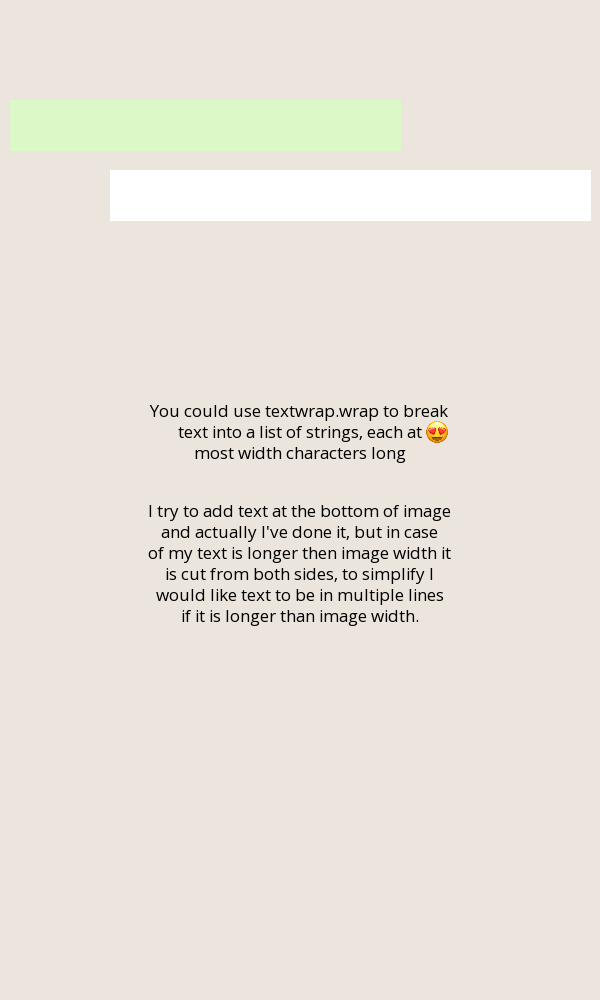

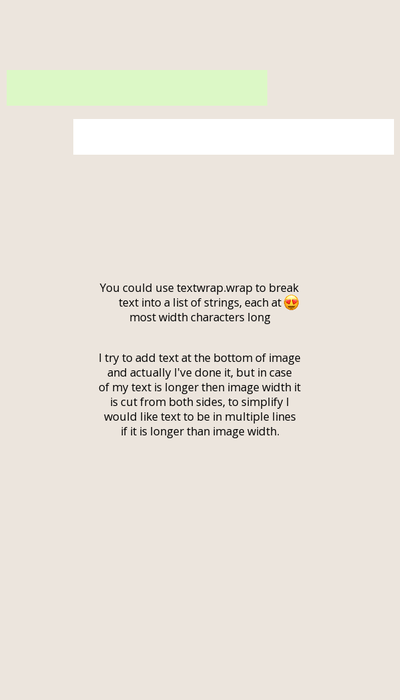

In [ ]:
img = cv2.imread('pil_text.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(img)
y = cv2.imread('resized.png', cv2.IMREAD_UNCHANGED)
cv2_imshow(y)